In [73]:
%run beam_simulator.py
%run visibility_simulator.py
%matplotlib inline
%run antpos
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import astropy.coordinates as coord
import astropy.units as u
from astropy import time
from matplotlib.colors import LogNorm
import scipy.constants as CNST1
from scipy import signal
from matplotlib.colors import LogNorm

In [3]:
#loadinng GLEAM Calague 70-200 MHz
datafile = pd.read_csv('GLEAM_Catalogue_flux_above_15Jy_70_237MHz.csv')

df = pd.DataFrame(data=datafile)

#Flux and spectral indeces best fit

data_bestfit = np.load('GLEAM_Catalogue_flux_above_15Jy_100_200MHz_best_fit_S_0_alpha.npy')

RA = np.deg2rad(df['RAJ2000'])
DEC =np.deg2rad(df['DEJ2000'])

RA_0,DEC_0 = 21.41100,-30.72100

$\textbf{GLEAM Bright Point Source Spartial Distribution}$

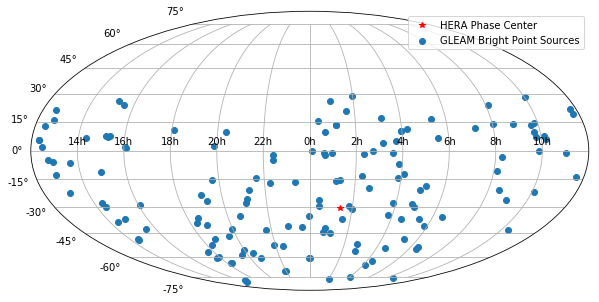

In [3]:
ra = coord.Angle(df['RAJ2000']*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(df['DEJ2000']*u.degree)

RA_0, DEC_0 = 21.41100,-30.72100 #degrees

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra.radian, dec.radian,label='GLEAM Bright Point Sources')
ax.plot(np.deg2rad(RA_0),np.deg2rad(DEC_0),'*r',label='HERA Phase Center')
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.legend(loc='best')
ax.grid(True)


$\textbf{HERA-19 Antenna Layout in ENU System}$

number of Antennas 56


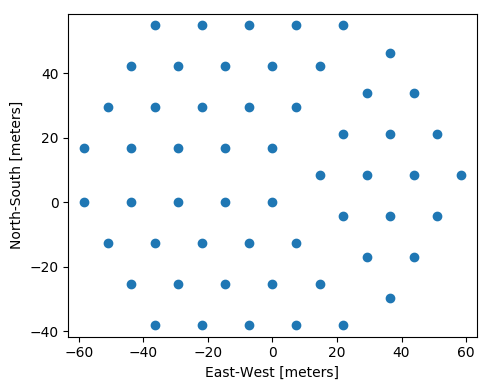

In [175]:
antposs = hex_array(5,split_core= True, outriggers=0)

hera_hex_pos = np.array([list(pos) for pos in antposs.values()])

print 'number of Antennas', len(hera_hex_pos[:,0])

plt.figure(figsize=(5,4), dpi=100)
plt.scatter(hera_hex_pos[:,0],hera_hex_pos[:,1])
plt.xlabel("East-West [meters]")
plt.ylabel("North-South [meters]")
plt.axis('equal')
plt.tight_layout()


$\textbf{Transform from ENU to XYZ}$

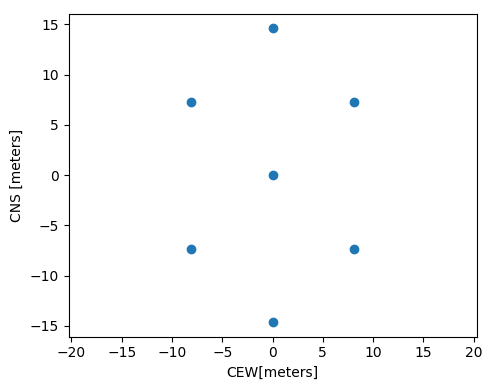

In [5]:
lat = -30.722

XYZ_array = np.array([XYZ_trans_mat(hera_hex_pos[i],lat)[0] for i in range(len(hera_hex_pos))])

plt.figure(figsize=(5,4), dpi=100)
plt.scatter(XYZ_array[:,0],XYZ_array[:,1])
plt.xlabel("CEW[meters]")
plt.ylabel("CNS [meters]")
plt.axis('equal')
plt.tight_layout()



$\textbf{Computing Baseline Vectors}$


With 56 antennas there are 235 unique baselines.


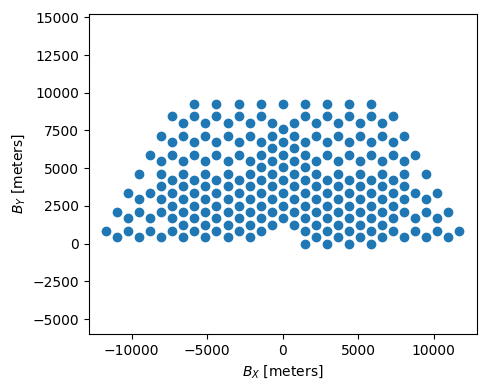

In [176]:


ants_indices = np.arange(len(hera_hex_pos))

ublDict = InterferometricArray(hera_hex_pos,ants_indices).CalculateUBLs()[4] #computing Unique Baselines


B_xyz = np.array(ublDict.keys())

plt.figure(figsize=(5,4), dpi=100)
plt.scatter(B_xyz[:,0],B_xyz[:,1])
plt.xlabel(r"$B_X$ [meters]")
plt.ylabel(r"$B_Y$ [meters]")
plt.axis('equal')
plt.tight_layout()


$\textbf{Simulating Visibility with Gaussian Primary Beam}$


In [177]:
RA_0,DEC_0 = 21.41100,-30.72100
lsts = np.array([np.deg2rad(0)]) #sources closer to the Zenith
freqs = np.linspace(140.0,160.0,100)

dish_diam =14.0
d_block = 0.0
a_theta_ant1= a_phi_ant1 = a_theta_ant2 =a_phi_ant2 =6.0 #meters
vis_gb={}
vis_ad={}

for ubl_i,redblock in ublDict.iteritems():
    
    vis_redblock_gb =np.zeros((len(redblock),freqs.size),dtype='complex')
    vis_redblock_ad =np.zeros((len(redblock),freqs.size),dtype='complex')
    for antspairs in range(len(redblock)):
        
        ant1, ant2 = hera_hex_pos[redblock[antspairs][1]],hera_hex_pos[redblock[antspairs][0]]
        
       
        vis_redblock_gb[antspairs] = vis_sim_gaussian_beam_bl(ant1,ant2,dish_diam,RA_0,DEC_0,RA,DEC,data_bestfit,freqs,lsts,0.0,0.0,0.0,0.0,0.0,0.0)
        
        vis_redblock_ad[antspairs] = vis_sim_airydisk_beam_bl(ant1,ant2,dish_diam,d_block,RA_0,DEC_0,RA,DEC,data_bestfit,freqs,lsts,a_theta_ant1,a_phi_ant1,0.0,0.0,a_theta_ant2,a_phi_ant2,0.0,0.0)

    vis_gb[ubl_i] =vis_redblock_gb
    vis_ad[ubl_i] =vis_redblock_ad
    

        

$\textbf{Simulating Visibility Noise}$



\begin{equation}
    \textit{T}_{sys}(\nu,\textit{t})= \eta_{\textrm{L}}\textit{T}_{\textrm{A}}(\nu,\textit{t})  + \textit{T}_{\textrm{R}}(\nu,\textit{t})
\end{equation}
with antenna temperature given by
\begin{equation}
    \textit{T}_{\textrm{A}}(\nu,\textit{t}) = \frac{\int \int \textit{P}(\theta,\phi,\nu) \textit{T}_{\textrm{sky}}(\theta,\phi,\nu,\textit{t})\sin(\theta)d\theta d\phi}{\int\int \textit{P}(\theta,\phi,\nu)\sin(\theta)d\theta d\phi}
\end{equation}
  where $\eta_{\textrm{L}}$ is the signal losses in the receiver.  Here $\textit{P}(\theta,\phi,\nu)$ is the antenna power pattern and $\textit{T}_{\textrm{sky}}$ is the brightness temperature in the sky during the observation time $\textit{t}$ seen by an antenna, which have the contribution from the cosmic background radiation, galactic emission, bright radio sources and ground temperature,

\begin{equation}
    \textit{T}_{\textrm{sky}}(\theta,\phi,\nu,\textit{t}) = \textit{T}_{\textrm{CMB}} + \textit{T}_{\textrm{gal}}(\theta,\phi,\nu,\textit{t}) + \textit{T}_{\textrm{radio}}(\theta,\phi,\nu,\textit{t})
\end{equation}


where $\textit{T}_{\textit{CMB}} =  2.725 $ $\rm{K}$, $\textit{T}_{\textrm{ground}} = 300$ $\textrm{K}$ the temperature of the surface (ignore scattering effect from neighboring antennas). In the case of sky with radio point sources only, then the antenna temperature becomes,


\begin{equation}
    \textit{T}_{\textrm{A}}(\nu,\textit{t}) = \frac{\sum_{\textit{q}}^{\textit{N}_{\textrm{src}}} \textit{P}(\theta_{\textit{q}},\phi_{\textit{q}},\nu) \textit{T}_{\textit{q}}(\nu)\sin(\theta_{\textit{q}})}{\sum_{\textit{q}}^{\textit{N}_{\textrm{src}} }\textit{P}(\theta_{\textit{q}},\phi_{\textit{q}},\nu)\sin(\theta_{\textit{q}})}
\end{equation}

The antenna noise is defined as 
\begin{equation}\label{eq:radm}
    \sigma(\nu,\textit{t}) = \frac{\textit{T}_{\textrm{sys}}(\nu,\textit{t})}{\sqrt{\Delta \nu \Delta \textit{t}}}
\end{equation}
where $\Delta \nu$ and $\Delta \textit{t}$ are frequency bandwidth and time integration per observation. 
Although the system noise temperature plays an important role on the determining interferometer sensitivity, however, Radio Interference Frequency Interference (RFI) can lead to deletion of the entire observation session if it not properly monitored. The following subsection is dedicated in discussing RFI impact on the interferometer sensitivity, and RFI mitigation techniques.




In [9]:
frq_mid = 150 # Central frequency in MHz
c=3e8
jy2K = 1e-26*(c/(frq_mid*1e6))**2/(2*CNST1.k)
def get_antenna_noise_pt_src(RA_0,DEC_0,RA,DEC,flux_cat,freq_array,freq_res,time_int,dish_diam=14.6,T_receiver =100,antenna_loss=0.8,ant1_theta_error=0.0,ant1_phi_error=0.0,Ant1_beam_size_error=0.0):
    
    
    T_sys = np.zeros(freq_array.size)
    
    for freq_i in range(freq_array.size):
        sigma_fwhm = sigma_func(dish_diam,freqs[freq_i]*10**6)
    
        T_sys[freq_i] = antenna_loss*(np.sum([np.power(gaussian_beam(np.deg2rad(RA_0),np.deg2rad(DEC_0),DEC[src_i],RA[src_i],sigma_fwhm,ant1_theta_error,ant1_phi_error,Ant1_beam_size_error),2)*flux_func(freqs[freq_i],flux_cat[src_i][0],flux_cat[src_i][1])*jy2K*np.sin(RA[src_i]) for src_i in range(len(RA))])/np.sum([np.power(gaussian_beam(np.deg2rad(RA_0),np.deg2rad(DEC_0),DEC[src_i],RA[src_i],sigma_fwhm,ant1_theta_error,ant1_phi_error,Ant1_beam_size_error),2)*np.sin(RA[src_i])for src_i in range(len(RA))])) + T_receiver
    
    noise = T_sys/np.sqrt(freq_res*time_int)
    
    return noise
    
freq_res = (freqs[1] -freqs[0])*10**6
time_int =112 #seconds
    
ant_noise =get_antenna_noise_pt_src(RA_0,DEC_0,RA,DEC,data_bestfit,freqs,freq_res,time_int)   
    

In [165]:

#add thermal noise    
vis_add_noise_gb = {}
vis_add_noise_ad = {}
for ubl_i,redblock in vis_gb.iteritems():
    vis_redblock_gb_noise_add =np.zeros((len(redblock),freqs.size),dtype='complex')
    vis_redblock_ad_noise_add =np.zeros((len(redblock),freqs.size),dtype='complex')
    for bl_i in range(len(redblock)):
        vis_redblock_gb_noise_add[bl_i] = [vis_gb[ubl_i][bl_i][freq_i] + ant_noise[freq_i]*ant_noise[freq_i] for freq_i in range(freqs.size)]
        vis_redblock_ad_noise_add[bl_i] = [vis_ad[ubl_i][bl_i][freq_i] + ant_noise[freq_i]*ant_noise[freq_i] for freq_i in range(freqs.size)]
    vis_add_noise_gb[ubl_i] = vis_redblock_gb_noise_add
    vis_add_noise_ad[ubl_i] = vis_redblock_ad_noise_add
    
    
    


In [23]:
ublDict

{(-5110, 1264, 0): [(3, 11), (7, 15)],
 (-4380, 2529, 0): [(0, 11), (3, 15), (7, 18)],
 (-3650, 1264, 0): [(0, 6), (3, 10), (4, 11), (7, 14), (8, 15), (12, 18)],
 (-3650, 3793, 0): [(0, 15), (3, 18)],
 (-2920, 2529, 0): [(0, 10), (1, 11), (3, 14), (4, 15), (7, 17), (8, 18)],
 (-2920, 5058, 0): [(0, 18)],
 (-2190, 1264, 0): [(0, 5),
  (1, 6),
  (3, 9),
  (4, 10),
  (5, 11),
  (7, 13),
  (8, 14),
  (9, 15),
  (12, 17),
  (13, 18)],
 (-2190, 3793, 0): [(0, 14), (1, 15), (3, 17), (4, 18)],
 (-1460, 2529, 0): [(0, 9),
  (1, 10),
  (2, 11),
  (3, 13),
  (4, 14),
  (5, 15),
  (7, 16),
  (8, 17),
  (9, 18)],
 (-1460, 5058, 0): [(0, 17), (1, 18)],
 (-730, 1264, 0): [(0, 4),
  (1, 5),
  (2, 6),
  (3, 8),
  (4, 9),
  (5, 10),
  (6, 11),
  (7, 12),
  (8, 13),
  (9, 14),
  (10, 15),
  (12, 16),
  (13, 17),
  (14, 18)],
 (-730, 3793, 0): [(0, 13), (1, 14), (2, 15), (3, 16), (4, 17), (5, 18)],
 (0, 2529, 0): [(0, 8),
  (1, 9),
  (2, 10),
  (3, 12),
  (4, 13),
  (5, 14),
  (6, 15),
  (8, 16),
  (9, 17

In [166]:
bl_ew = (5840, 0, 0)
vis_gb_ew ={}
vis_ad_ew ={}

vis_gb_ns ={}
vis_ad_ns ={}
for bl_i in ublDict.keys():
    if np.rad2deg(np.arccos(np.dot(bl_i,bl_ew)/(np.linalg.norm(bl_i)*np.linalg.norm(bl_ew)))) == 0.0 :
        vis_gb_ew[bl_i] = vis_gb[bl_i]
        vis_ad_ew[bl_i] = vis_ad[bl_i]
        
    elif np.rad2deg(np.arccos(np.dot(bl_i,bl_ew)/(np.linalg.norm(bl_i)*np.linalg.norm(bl_ew)))) == 90.0:
        vis_gb_ns[bl_i] = vis_gb[bl_i]
        vis_ad_ns[bl_i] = vis_ad[bl_i]
        
    else:
        
        pass
    
        
    

In [167]:
blvecs = vis_gb_ew.keys()
blvecs_sorted = sorted(blvecs)


vis_gb_add_noise_sorted_ew = np.array([vis_gb_ew[blvecs_sorted[i]][0] for i in range(len(blvecs_sorted))])
vis_ad_add_noise_sorted_ew = np.array([vis_ad_ew[blvecs_sorted[i]][0] for i in range(len(blvecs_sorted))])

$\textbf{Delay Power Spectrum}$

The delay power spectrum $\textit{P}(\textit{k}_{\parallel},\textit{k}_{\perp})$ is related to the diagonal of covariance matrix of the Fourier domain visibility $\textit{u}(\mathbf{u},\tau)$ as follows

\begin{equation}
\textit{P}(\textit{k}_{\parallel},\textit{k}_{\perp}) = \Big(\frac{\lambda^2}{2\textit{k}_{\textrm{B}}}\Big)^2\Big(\frac{\textit{D}^2\Delta \textit{D}}{\Delta\textit{B}}\Big)\Big(\frac{1}{\Omega\Delta \textit{B}}\Big) \langle |\textit{u}(\mathbf{u},\tau)|^2\rangle
\end{equation}
where 

\begin{equation}
\textit{k}_{\perp} = \frac{2\pi\mathbf{b}}{\lambda\textit{D}(\textit{z})}
\end{equation}
and 
\begin{equation}
\textit{k}_{\parallel} \approx\frac{2\pi\tau}{\Delta \textit{D}(\textit{z})}
\end{equation}
are wavenumber in the line-of-sight and transeverse directions. Here $\textit{D}(\textit{z})$ is the transeverse comoving distance at redshift $\textit{z}$, and $\Delta \textit{D}(\textit{z})$ is the line-of-sight comoving width of the   observation bandwidth at redshift $\textit{z}$, if $\textit{B}$ is set to be bandwidth;

\begin{equation}
\Delta \textit{D}(\textit{z}) \approx\frac{\textit{c}(1+\textit{z})^2}{\textit{H}_0\textit{f}_{21}\textit{E}(\textit{z})}\Delta \textit{B}
\end{equation}
where $\textit{c}$ is the speed of light in vaccum, and $\textit{H}_0$ and $E(z)=[\Omega _{\rm M}(1+z)^3+\Omega _k(1+z)^2+\Omega _\Lambda ]^{1/2}$ are standard terms in cosmology. The effective bandwidth is given by
\begin{equation}
\Delta\textit{B} = \int_{-\textit{B}/2}^{\textit{B}/2} \textit{W}(\textit{f})\textit{d}\textit{f}
\end{equation}
and 
\begin{equation}
\Omega = \int_{4\pi}\textit{A}(\hat{s},\textit{f})\textit{d}\Omega
\end{equation}

where $\textit{W}(\textit{f})$  and $\textit{A}(\hat{s},\textit{f})$ is window function at frequency $\textit{f}$ and antenna angular response at function positon $\hat{s}$ in celestial sphere, respectively. The delay visibility are given by

\begin{equation}
\textit{u}(\mathbf{u},\tau) = \int \textit{u}(\mathbf{u},\textit{f})\textit{e}^{-j2\pi\textit{f}\tau} \textit{d}\textit{f}
\end{equation}
where $\tau$ is a Fourier conjugate of $\textit{f}$. Here $j=\sqrt{-1}$, $\lambda$ is the observing wavelenght and $\textit{k}_{\textrm{B}}$.

reference

https://iopscience.iop.org/article/10.1088/0004-637X/776/1/6



In [13]:
from astropy.cosmology import FlatLambdaCDM 
import scipy.integrate  as intg
from scipy.integrate import dblquad


$\textbf{Comoving Transverse Distance $ \textit{D}$}$

Text(0,0.5,'Comoving Distance [Mpc]')

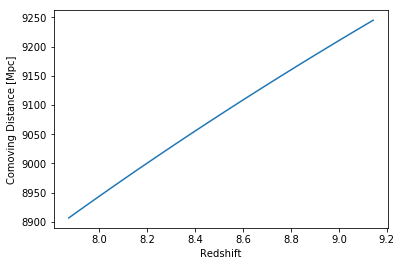

In [14]:
cosm = FlatLambdaCDM(70.0,0.3) #standard cosmology

get_redshift = lambda f_0,f: (f_0/f) -1.0
f_0 = 1420
z_values = [get_redshift(f_0,freqs[j]) for j in range(freqs.size)]

comoving_distance= cosm.comoving_transverse_distance(z_values)

plt.plot(z_values,comoving_distance)
plt.xlabel('Redshift')
plt.ylabel('Comoving Distance [Mpc]')

$\textbf{Bandwidth $\Delta \textit{B}$}$

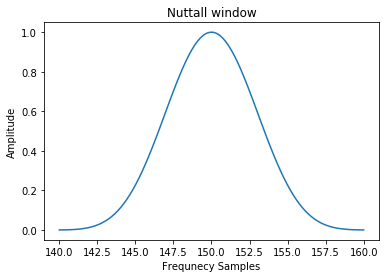

Bandwidth is 7.271640633082994 MHz


In [15]:
def get_bandwidth(window_func,frqs,dfreq =1.0):
    "This function compute the bandwidth given the window function as an array, and freqs array where it is sampled"
    
    bandwidth = intg.simps(window_func,frqs,dfreq)
    
    return bandwidth

window = signal.nuttall(freqs.size)


plt.plot(freqs,window)
plt.title("Nuttall window")
plt.ylabel("Amplitude")
plt.xlabel("Frequnecy Samples")
plt.show()

print 'Bandwidth is', get_bandwidth(window,freqs),'MHz'

$\textbf{Line-of-sight Comoving Width $\Delta \textit{D}$}$

70.0


Text(0,0.5,'Comoving Width [Mpc]')

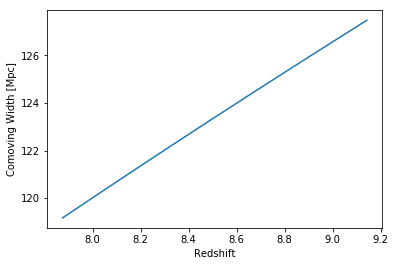

In [125]:
def get_comoving_width(z_values,bandwidth,f_21=1420):

    c = 3e8 # speed of light in vaccum
    comv_width = ((c*(np.ones(len(z_values))+z_values)**2)/(f_21*cosm.H(z_values).value*1000))*bandwidth
    
    return comv_width


    
    

print cosm.H0.value
plt.plot(z_values,get_comoving_width(z_values,get_bandwidth(window,freqs)))
plt.xlabel('Redshift')
plt.ylabel('Comoving Width [Mpc]')

$\textbf{Total Solid Angle $\Omega$}$

In [17]:
def omega_gaussian_beam(dish_diam,frqs,dfrqs=1.0):
    omeg_frq = np.zeros(len(frqs))
    for freq_i in range(frqs.size):
        sigma_value = sigma_func(dish_diam,frqs[freq_i]) 
        omeg_frq[freq_i] = dblquad(lambda theta,phi,theta_c, phi_c,sigma_fwhm,e_theta,e_phi,e_sigma : gaussian_beam(theta_c, phi_c,theta,phi,sigma_fwhm,e_theta,e_phi,e_sigma),-np.pi,np.pi,-np.pi/2.0,np.pi/2.0, args=(0.0,0.0,sigma_value,0.0,0.0,0.0))[0]
    Omega = intg.simps(omeg_frq,frqs,dfrqs)
    
    return Omega

omega_gaussian_beam(14.0,freqs)

394.78417583781857

$\textbf{$\textit{k}_{\perp}$ and $\textit{k}_{\parallel}$ }$

\begin{equation}
\textit{k}_{\perp} = \frac{2\pi\mathbf{b}}{\lambda\textit{D}(\textit{z})}
\end{equation}
and 
\begin{equation}
\textit{k}_{\parallel} \approx\frac{2\pi\tau}{\Delta \textit{D}(\textit{z})}
\end{equation}

In [117]:
def get_k_perp(blvec,freq_i,f_0 = 1420,c=3e8):
    
    "Compute the k-perpducular"
   
    
    wavelen = c/(freq_i*10**6)
    
    redshift = get_redshift(f_0,freq_i)
    
    comoving_distance_transv = cosm.comoving_transverse_distance(redshift).value
    
    k_x,k_y = 2.0*np.pi*blvec[0]/(wavelen*comoving_distance_transv), 2.0*np.pi*blvec[1]/(wavelen*comoving_distance_transv)
    k_perp = np.sqrt(k_x**2 + k_y**2)
    return k_perp


def get_k_parall(freq_array,f_0=1420):
    
    "Compute k-parallel"
    window_func = signal.nuttall(freq_array.size)
    
    delays = np.fft.fftfreq(freq_array.size,freq_array[1]-freq_array[0])
    delays = np.fft.fftshift(delays)
    
    pos_delays = delays[delays.size/2:]
    neg_delays = delays[:delays.size/2]
    redshift = [get_redshift(f_0,freq_array[j]) for j in range(freq_array.size)]
    
    comoving_dist_lof = get_comoving_width(redshift,get_bandwidth(window_func,freq_array))
    
    
    k_par=  2.0*np.pi*delays/comoving_dist_lof
    
    
    return k_par

def get_wedge(k_perp,freq_i,f_0 = 1420,c=3e8):
    
    redshift = get_redshift(f_0,freq_i)
    
    k_par = (cosm.H0.value*cosm.H(redshift).value*1e6)/(c*(1 +redshift))*k_perp
    
    return k_par
    


k_perp =np.array([get_k_perp(blvecs[j],150.0) for j in range(len(blvecs))])

k_par = get_k_parall(freqs)




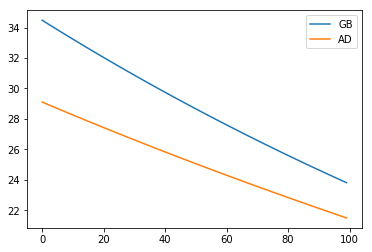

In [47]:
plt.plot(np.abs(vis_gb_add_noise_sorted_ew[0]),label='GB')
plt.plot(np.abs(vis_ad_add_noise_sorted_ew[0]),label='AD')
plt.legend(loc='best')

$\textbf{Delay Transform Visibility}$

In [170]:


def get_delay_vis(data,window,frqs):
    delay_data=np.fft.ifft(data*window)
    delaydata_shift=np.fft.fftshift(delay_data)
    delays = np.fft.fftfreq(frqs.size,frqs[1]-frqs[0])
    delays = np.fft.fftshift(delays)
    
    return [delays,delaydata_shift]

frq_mid = 150 # Central frequency in MHz
c=3e8
jy2mK = 1e-26*(c/(frq_mid*1e6))**2/((2*CNST1.k)*1e3)


blvecs=[[np.power(4,2),0.0,0.0],[np.power(4,3),0.0,0.0],[np.power(4,4),0.0,0.0],[np.power(4,5),0.0,0.0]]

def geometric_delay(bl):
    return bl/c

bl= 14.6
g_dl_vecs = [geometric_delay(np.linalg.norm(blvecs_sorted[bl_i])) for bl_i in range(len(blvecs_sorted))]

delays = np.fft.fftfreq(freqs.size,freqs[1]*10**6-freqs[0]*10**6)
delays = np.fft.fftshift(delays)
ddata_gb = np.array([get_delay_vis(vis_gb_add_noise_sorted_ew[bl_i]*jy2mK,window,freqs)[1] for bl_i in range(vis_gb_add_noise_sorted_ew.shape[0])])
ddata_ad = np.array([get_delay_vis(vis_ad_add_noise_sorted_ew[bl_i]*jy2mK,window,freqs)[1] for bl_i in range(vis_ad_add_noise_sorted_ew.shape[0])])



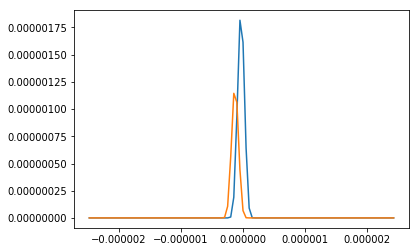

In [126]:
bllen = [np.linalg.norm(blvecs_sorted[i]) for i in range(len(blvecs_sorted))]

k_perp =np.array([get_k_perp(blvecs_sorted[j],150.0) for j in range(len(blvecs_sorted))])

k_par = get_k_parall(freqs)

print k_par

[-0.12199816 -0.11964501 -0.11728825 -0.1149279  -0.11256395 -0.11019641
 -0.10782529 -0.10545058 -0.10307229 -0.10069043 -0.098305   -0.095916
 -0.09352343 -0.0911273  -0.08872762 -0.08632438 -0.0839176  -0.08150726
 -0.07909339 -0.07667598 -0.07425503 -0.07183055 -0.06940254 -0.066971
 -0.06453595 -0.06209738 -0.05965529 -0.05720969 -0.05476059 -0.05230798
 -0.04985187 -0.04739227 -0.04492917 -0.04246259 -0.03999251 -0.03751896
 -0.03504192 -0.03256141 -0.03007743 -0.02758998 -0.02509906 -0.02260468
 -0.02010684 -0.01760555 -0.0151008  -0.0125926  -0.01008096 -0.00756588
 -0.00504735 -0.00252539  0.          0.00252882  0.00506107  0.00759674
  0.01013583  0.01267833  0.01522425  0.01777358  0.02032632  0.02288246
  0.025442    0.02800493  0.03057126  0.03314098  0.03571409  0.03829058
  0.04087046  0.04345371  0.04604034  0.04863034  0.05122371  0.05382044
  0.05642054  0.059024    0.06163081  0.06424098  0.0668545   0.06947136
  0.07209157  0.07471513  0.07734202  0.07997224  0.082

Text(0,0.5,'$k_{\\parallel}[Mpc^-1]$')

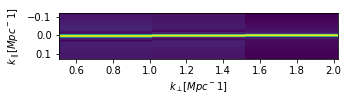

In [174]:
extent =[k_perp[0],k_perp[-1],k_par[-1],k_par[0]]

plt.figure(figsize=(5,20))
plt.imshow(np.abs(ddata_gb.T),extent=extent,norm=LogNorm())
plt.xlabel(r'$k_{\perp}[Mpc^-1]$')
plt.ylabel(r'$k_{\parallel}[Mpc^-1]$')




$\textbf{Delay Power Spectrum}$


\begin{equation}
\textit{P}(\textit{k}_{\parallel},\textit{k}_{\perp}) = \Big(\frac{\lambda^2}{2\textit{k}_{\textrm{B}}}\Big)^2\Big(\frac{\textit{D}^2\Delta \textit{D}}{\Delta\textit{B}}\Big)\Big(\frac{1}{\Omega\Delta \textit{B}}\Big) \langle |\textit{u}(\mathbf{u},\tau)|^2\rangle
\end{equation}

In [148]:
def get_delay_ps(freq_array,bl_dtvis,f_0=1420,c=3e8,k=CNST1.k):
    
    "Compute Delay Power Spectrum"
    
    window_func = signal.nuttall(freq_array.size)
    
    redshift = [get_redshift(f_0,freq_array[j]) for j in range(freq_array.size)]
    
    comvoing_dist_trans = cosm.comoving_transverse_distance(redshift).value
    comoving_width_lof =get_comoving_width(redshift,get_bandwidth(window_func,freq_array))
    
    bandwidth = get_bandwidth(window_func,freq_array)
    omega = omega_gaussian_beam(14.0,freq_array)
    
    cf = [(np.power(((c/(freq_array[freq_j]*10**6))**2)/(2*k*1e3),2)*(comvoing_dist_trans[freq_j]*comoving_width_lof[freq_j])/(np.power(bandwidth,2)*10**6))*1.0/(omega) for freq_j in range(freq_array.size)]
  
    ps = cf*np.power(np.abs(bl_dtvis),2)
    
    #print cf
    
    return ps


ddata_gb[0].size


    
    
dps = np.array([get_delay_ps(freqs,ddata_ad[j]) for j in range(ddata_gb.shape[0])])

  

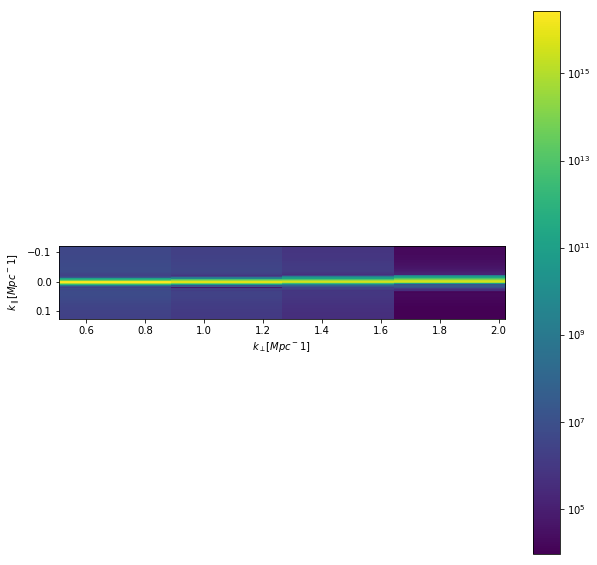

In [173]:

extent =[k_perp[0],k_perp[-1],k_par[-1],k_par[0]]

plt.figure(figsize=(10,10))
plt.imshow(dps.T,extent=extent,norm=LogNorm())
plt.xlabel(r'$k_{\perp}[Mpc^-1]$')
plt.ylabel(r'$k_{\parallel}[Mpc^-1]$')
plt.colorbar()